### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [2]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gsw
import gc
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists
sns.set_context("notebook")
import dask_labextension

In [3]:
from pathlib import Path
from natsort import natsorted

In [4]:
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies
def remove_daily_climatology(ds):
    climatology = ds.groupby("time.dayofyear").mean("time")
    anomalies = ds.groupby("time.dayofyear") - climatology
    return anomalies

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='100GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=8)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=94G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.56:34946 --nthreads 36 --memory-limit 93.13GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.56:34946,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Reading in the GLORYS and ERA5 data files. Files have been preprocessed and combined in order to take advantage of the **dask** feature of xarray. We also remove their seasonal cliamtologies

In [7]:
%%time 
chunk_size = -1
def _preprocess(ds):
    return ds.sel(latitude = slice(-2, 60), longitude = slice(-150, -75))
ds = xr.open_mfdataset(
        GLORYS_data_dir("GLORYS_NE_PAC.nc"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        preprocess=_preprocess,
        parallel=True,
        chunks={"time":120, "latitude":chunk_size, "longitude":chunk_size, "depth":1},
        engine="netcdf4")

CPU times: user 270 ms, sys: 55.1 ms, total: 325 ms
Wall time: 3.09 s


In [8]:
def bathy_preprocess(ds):
    return ds.sel(depth = ds.depth.values, method = "nearest").sel(latitude = slice(-2, 60), 
                        longitude = slice(-150, -75))

bathy_ds = xr.open_mfdataset(GLORYS_data_dir("CaliforniaCoastalMask.nc"), 
                             preprocess=_preprocess,
                             parallel=True, 
                            chunks={"latitude":chunk_size, "longitude":chunk_size, "depth":1},
                            engine="netcdf4")
weighted_mask_ds = xr.open_mfdataset(GLORYS_data_dir("CaliforniaCoastalMaskWeighted.nc"), 
                             preprocess=_preprocess,
                             parallel=True, 
                            chunks={"latitude":chunk_size, "longitude":chunk_size, "depth":1},
                            engine="netcdf4")
LON, LAT = np.meshgrid(ds.longitude.values, ds.latitude.values)

In [9]:
def zonal_average_coastline(var): 
    var_dict = dict()
    var_dict["GC_E"]  = (weighted_mask_ds.GC_E * var).sum(dim = "longitude") / (weighted_mask_ds.GC_E).sum(dim = "longitude")
    var_dict["GC_W"] = (weighted_mask_ds.GC_W * var).sum(dim = "longitude") / (weighted_mask_ds.GC_W).sum(dim = "longitude")
    var_dict["GC_C"] = (weighted_mask_ds.GC_C * var).sum(dim = "longitude") / (weighted_mask_ds.GC_C).sum(dim = "longitude")
    var_dict["EQ"] = (weighted_mask_ds.EQ * var).sum(dim = "latitude") / (weighted_mask_ds.EQ).sum(dim = "latitude")
    var_dict["SW"] = (weighted_mask_ds.SW * var).sum(dim = "latitude") / (weighted_mask_ds.SW).sum(dim = "latitude")
    var_dict["NW"] = (weighted_mask_ds.NW * var).sum(dim = "longitude") / (weighted_mask_ds.NW).sum(dim = "longitude")
    var_dict["COL"] = (weighted_mask_ds.COL * var).sum(dim = "longitude") / (weighted_mask_ds.COL).sum(dim = "longitude")
    return var_dict

#only pick dry points when the variables varies with depth
#if we do not use this then the above function will overcount the number of actual point available
def zonal_average_coastline_depth(var): 
    var_dict = dict()
    var_dict["GC_E"]  = (weighted_mask_ds.GC_E * var).sum(dim = "longitude") / (weighted_mask_ds.GC_E * bathy_ds.wet_mask).sum(dim = "longitude")
    var_dict["GC_W"] = (weighted_mask_ds.GC_W * var).sum(dim = "longitude") / (weighted_mask_ds.GC_W * bathy_ds.wet_mask).sum(dim = "longitude")
    var_dict["GC_C"] = (weighted_mask_ds.GC_C * var).sum(dim = "longitude") / (weighted_mask_ds.GC_C * bathy_ds.wet_mask).sum(dim = "longitude")
    var_dict["EQ"] = (weighted_mask_ds.EQ * var).sum(dim = "latitude") / (weighted_mask_ds.EQ * bathy_ds.wet_mask).sum(dim = "latitude")
    var_dict["SW"] = (weighted_mask_ds.SW * var).sum(dim = "latitude") / (weighted_mask_ds.SW * bathy_ds.wet_mask).sum(dim = "latitude")
    var_dict["NW"] = (weighted_mask_ds.NW * var).sum(dim = "longitude") / (weighted_mask_ds.NW * bathy_ds.wet_mask).sum(dim = "longitude")
    var_dict["COL"] = (weighted_mask_ds.COL * var).sum(dim = "longitude") / (weighted_mask_ds.COL * bathy_ds.wet_mask).sum(dim = "longitude")
    return var_dict

def stitch_zonal_average(d):
    var_list = []
    for key in ["EQ", "COL", "SW", "GC_E", "GC_C", "GC_W", "NW"]:
        d[key] = d[key].compute()
        if key == "EQ":
            var = d[key][~np.isnan(d[key])].compute().values
        else:
            if key == "GC_C":
                print(key)
                var = d[key][~np.isnan(d[key])].compute().values[::-1]
            elif key == "SW":
                print(key)
                var = d[key][~np.isnan(d[key])].compute().values[::-1]
            else:
                var = d[key][~np.isnan(d[key])].compute().values

        var_list = np.concatenate((var_list, var))
    return var_list 
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r


In [10]:
latitudes = zonal_average_coastline(LAT)
longitudes = zonal_average_coastline(LON)
list_lats = stitch_zonal_average(latitudes)
list_lons = stitch_zonal_average(longitudes)

SW
GC_C
SW
GC_C


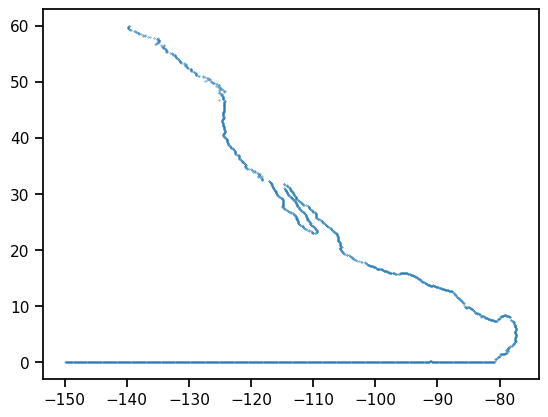

In [11]:
dists = []
for i in range(0, len(list_lats)-1):
    a = haversine(list_lons[i], list_lats[i], list_lons[i+1], list_lats[i+1])
    dists = np.concatenate([dists, [a]])
cum_distance = np.concatenate([[0.0], np.cumsum(dists)]) 
plt.scatter(list_lons, list_lats, s = 0.1)

In [12]:
%%time
zos_dict = zonal_average_coastline(ds["zos"])
theta_dict = zonal_average_coastline_depth(ds["thetao"])
for key in ["EQ", "COL", "SW", "GC_E", "GC_C", "GC_W", "NW"]:
    print(key)
    zos_dict[key] = zos_dict[key].compute()
    theta_dict[key] = theta_dict[key].compute()

EQ
COL
SW
GC_E
GC_C
GC_W
NW
CPU times: user 1min 35s, sys: 8.23 s, total: 1min 43s
Wall time: 19min 28s


In [13]:
def stich_zonal_average_xr(ds_dict):
    var_list = []
    n_dist1 = 0
    for key in ["EQ", "COL", "SW", "GC_E", "GC_C", "GC_W", "NW"]:
        if key == "EQ":
            var = ds_dict[key].isel(longitude = np.where(~np.isnan(longitudes[key]))[0])
            var = var.rename({'longitude': 'distance'})
        else:
            if key == "GC_C":
                var = ds_dict[key].isel(latitude = np.where(~np.isnan(latitudes[key]))[0]).isel(latitude=slice(None, None, -1))
                var = var.rename({'latitude': 'distance'})
            elif key == "SW":
                var = ds_dict[key].isel(longitude = np.where(~np.isnan(longitudes[key]))[0]).isel(longitude=slice(None, None, -1))
                var = var.rename({'longitude': 'distance'})
            else:
                var = ds_dict[key].isel(latitude = np.where(~np.isnan(latitudes[key]))[0])
                var = var.rename({'latitude': 'distance'})

        n_dist2 = len(var.distance)
        var = var.assign_coords({"distance": cum_distance[n_dist1:n_dist1+n_dist2]})
        n_dist1 = n_dist2 + n_dist1
        var_list = var_list + [var]
    return var_list

In [14]:
theato_coast = xr.concat(stich_zonal_average_xr(theta_dict), dim = "distance"); theato_coast.name = "thetao"
zos_coast = xr.concat(stich_zonal_average_xr(zos_dict), dim = "distance"); zos_coast.name = "zos"
coast_vars = xr.merge([theato_coast, zos_coast], compat='override')

In [15]:
coast_vars.distance.attrs['units'] = 'km'
coast_vars.zos.attrs['units'] = 'm'
coast_vars.thetao.attrs['units'] = 'deg C'

In [16]:
hovmoller_ds = xr.Dataset(
        data_vars=dict(
        lat_path=(["distance"], list_lats ),
        lon_path=(["distance"], list_lons)
     ),
     coords=dict(
         distance=(["distance"], cum_distance),
         time=ds.time.values,
     ),)

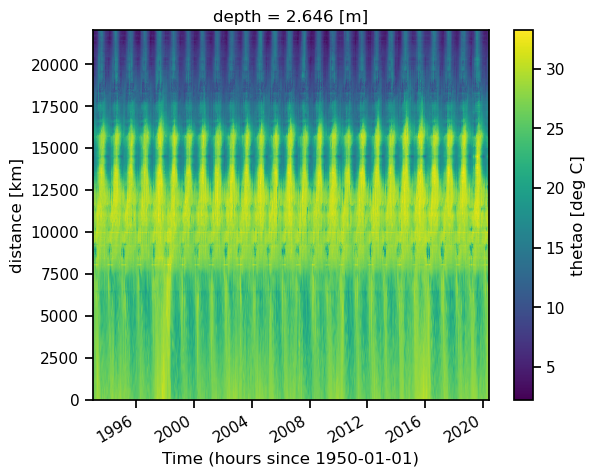

In [17]:
coast_vars.thetao.isel(depth =2).plot()

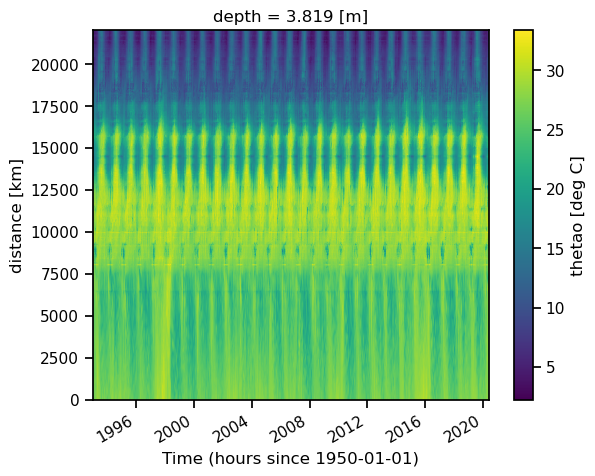

In [18]:
coast_vars.thetao.isel(depth =3).plot()

In [19]:
hovmoller_ds

<xarray.Dataset>
Dimensions:   (distance: 1908, time: 10013)
Coordinates:
  * distance  (distance) float64 0.0 9.269 18.54 ... 2.203e+04 2.204e+04
  * time      (time) datetime64[ns] 1993-01-01T12:00:00 ... 2020-05-31T12:00:00
Data variables:
    lat_path  (distance) float64 6.331e-08 6.331e-08 6.331e-08 ... 59.83 59.92
    lon_path  (distance) float64 -149.9 -149.8 -149.7 ... -139.8 -139.7 -139.6

In [20]:
hovmoller_mask_dict = zonal_average_coastline(bathy_ds[["EQ", "COL", "SW", "GC_E", "GC_C", "GC_W", "NW"]])

for key in ["EQ", "COL", "SW", "GC_E", "GC_C", "GC_W", "NW"]:
    print(key)
    hovmoller_mask_dict[key] = hovmoller_mask_dict[key].compute()

EQ
COL
SW
GC_E
GC_C
GC_W
NW


In [21]:
hovmoller_mask_ds =  xr.concat(stich_zonal_average_xr(hovmoller_mask_dict), dim = "distance")
hovmoller_ds = xr.merge([hovmoller_ds, hovmoller_mask_ds])
hovmoller_ds.distance.attrs['units'] = 'km'

In [26]:
coast_vars.to_netcdf(GLORYS_data_dir("GLORYS_Coastal_Vars.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)
hovmoller_ds.to_netcdf(GLORYS_data_dir("GLORYS_Coastal_Path.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)